In [1]:
import torch
from PIL import Image
from pathlib import Path
from models_train.IQAmodel import IQAModel
from torchvision.transforms.functional import resize, to_tensor, normalize
from torch.autograd import Variable
from matplotlib import pyplot as plt
from tqdm import tqdm
import numpy as np
from torchvision import datasets, transforms

In [4]:
activation = "relu"
arch = "resnet50"
testset_path = "./NIPS_test/"
checkpoints_path = "weights/activation={}-{}-{}-loss=norm-in-norm-p=1.0-q=2.0-detach-False-KonIQ-10k-res={}-{}x{}" \
    .format(activation, "Linearity", arch, True, 498, 664)

In [5]:
checkpoints = torch.load(checkpoints_path, map_location="cuda")
model = IQAModel("Linearity", arch=arch, pool="avg", use_bn_end=False, P6=1, P7=1, activation=activation, se=False, pruning=None).cuda()
model.load_state_dict(checkpoints["model"])
k = checkpoints["k"]
b = checkpoints["b"]
mmin = checkpoints["min"]
mmax = checkpoints["max"]
model.eval()
print(mmin, mmax)

11.768364320878657 85.66422470919554


In [7]:
def normalizer(output, mmin, mmax):
    return (output-mmin)/(mmax-mmin)

In [10]:
def attack(image, model, range_, eps):
    # img = image.unsqueeze(0)
    # additive = Variable(torch.zeros_like(img).cuda(), requires_grad=True)
    # loss_fn = lambda x : 1 - (x[-1]*k[0]+b[0])/range_
    # img = img+additive
    # output = model(img)
    # loss = loss_fn(output)
    # loss.backward()
    # input_grad = additive.grad.data
    # grad_sign = input_grad.sign()
    # additive.data -= eps*grad_sign
    # return additive.squeeze(0)

    # img = image.clone()
    # img = img.requires_grad_(True)
    # loss_fn = lambda x : 1 - (x[-1]*k[0]+b[0])/range_
    # output = model(normalize(img.unsqueeze(0), [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]))
    # loss = loss_fn(output)
    # model.zero_grad()
    # loss.backward()
    # perturbation = eps*img.grad.data.sign()
    # attacked_img = image-perturbation
    # return attacked_img.clamp_(0,1)

    img = image.clone()
    # img = img.unsqueeze(0)
    # img = normalize(img, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    img.requires_grad_(True)
    loss_fn = lambda x : 1 - (x[-1]*k[0]+b[0])/range_

    output = model(img)
    loss = loss_fn(output)
    model.zero_grad()
    loss.backward()
    input_grad = img.grad.data
    img.data -= eps*input_grad.sign()

    return img
    

  0%|                                          | 1/1000 [00:00<03:32,  4.70it/s]

0.3959789276123047 0.4122135043144226 0.01623457670211792


  0%|▏                                         | 3/1000 [00:00<03:17,  5.04it/s]

0.4007973372936249 0.41886237263679504 0.018065035343170166
0.40537890791893005 0.41577088832855225 0.010391980409622192


  0%|▏                                         | 3/1000 [00:00<04:22,  3.80it/s]


0.40029263496398926 0.4125056564807892 0.012213021516799927


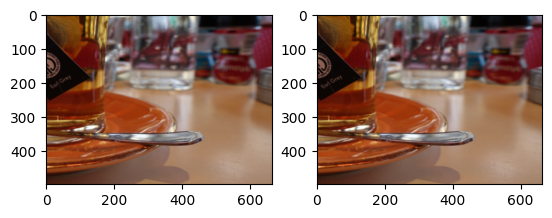

In [22]:

fig, axs = plt.subplots(1,2)
count = 4
for image_path in tqdm(Path(testset_path).iterdir(),total=len([x for x in Path(testset_path).iterdir()])):
    im = Image.open(image_path).convert("RGB")
    im = resize(im, (498, 664))
    axs[0].imshow(im)
    im = to_tensor(im).cuda()
    # im = normalize(im, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    # additive = attack(im, model, mmax-mmin, 10/255)
    # im_attack = im+additive
    # im_attack.clamp_(0,1)
    # im_attack = attack(im, model, mmax-mmin, 10/255).squeeze(0)
    # axs[1].imshow(np.moveaxis(im_attack.detach().cpu().numpy(),0,-1))
    # val = model(normalize(im.unsqueeze(0), [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]))[-1]*k[0]+b[0]
    # val = normalizer(val, k, b, mmin, mmax)
    # attacked_val = model(normalize(im_attack.unsqueeze(0), [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]))[-1]*k[0]+b[0]
    # attacked_val = normalizer(attacked_val, k, b, mmin, mmax)

    im = im.unsqueeze(0)
    # im = normalize(im, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    im_attacked = attack(im, model, mmax-mmin, 2/255)
    
    # aim = normalize(normalize(im_attacked.squeeze(0), [0,0,0], [1/0.229,1/0.224,1/0.225]), [-0.485,-0.456,-0.406],[1,1,1])
    aim.data.clamp_(0,1)
    # im_attacked = normalize(aim.unsqueeze(0), [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    axs[1].imshow(np.moveaxis(aim.detach().cpu().numpy(),0,-1))

    val = model(im)[-1]*k[0]+b[0]
    attacked_val = model(im_attacked)[-1]*k[0]+b[0]
    
    val = normalizer(val, mmin, mmax)
    attacked_val = normalizer(attacked_val, mmin, mmax)
    print(val.item(), attacked_val.item(), attacked_val.item()-val.item())
    count -=1
    if count==0:
        break
    

In [ ]:
activation = "relu"
arch = "wideresnet50"

epss = [2/255, 4/255, 6/255, 8/255, 10/255]
gains = [ [] for _ in range(5)]
for e, eps in enumerate(epss):
    for image_path in tqdm(Path(testset_path).iterdir(),total=len([x for x in Path(testset_path).iterdir()])):
        im = Image.open(image_path).convert("RGB")
        im = to_tensor(im).cuda()
        # im = normalize(im, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        # im_attack = attack(im, model, mmax-mmin, eps)
        im_attack = attack(im, model, mmax-mmin, eps).squeeze(0)
        val = model(normalize(im.unsqueeze(0), [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]))[-1]*k[0]+b[0]
        val = normalizer(val, k, b, mmin, mmax)
        attacked_val = model(normalize(im_attack.unsqueeze(0), [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]))[-1]*k[0]+b[0]
        attacked_val = normalizer(attacked_val, k, b, mmin, mmax)
        # print(val.item(), attacked_val.item(), attacked_val.item()-val.item())
        gains[e].append(attacked_val.item() - val.item())

In [25]:
activation = "relu"
arch = "resnet50"

epss = [2/255, 4/255, 6/255, 8/255, 10/255]
gains = [ [] for _ in range(5)]
for e, eps in enumerate(epss):
    for image_path in tqdm(Path(testset_path).iterdir(),total=len([x for x in Path(testset_path).iterdir()])):
        im = Image.open(image_path).convert("RGB")
        im = to_tensor(im).cuda()
        im = normalize(im.unsqueeze(0), [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        im_attacked = attack(im, model, mmax-mmin, eps)
        val = model(im)[-1]*k[0]+b[0]
        attacked_val = model(im_attacked)[-1]*k[0]+b[0]
    
        val = normalizer(val, mmin, mmax)
        attacked_val = normalizer(attacked_val, mmin, mmax)
        # aim = normalize(normalize(im_attacked.squeeze(0), [0,0,0], [1/0.229,1/0.224,1/0.225]), [-0.485,-0.456,-0.406],[1,1,1])
        # print(val.item(), attacked_val.item(), attacked_val.item()-val.item())
        gains[e].append(attacked_val.item() - val.item())

100%|███████████████████████████████████████| 1000/1000 [01:15<00:00, 13.21it/s]


In [26]:
print(arch)
for e, eps in enumerate(epss):
    print("eps", int(eps*255), np.array(gains[e]).mean())

resnet50
eps 2 0.20683343875408172
eps 4 0.27844313967227935
eps 6 0.3080415028333664
eps 8 0.3171664244532585
eps 10 0.31545977866649627


In [67]:
activation = "relu"
arch = "wideresnet50"

epss = [2/255, 4/255, 6/255, 8/255, 10/255]
gains = [ [] for _ in range(5)]
for e, eps in enumerate(epss):
    for image_path in tqdm(Path(testset_path).iterdir(),total=len([x for x in Path(testset_path).iterdir()])):
        im = Image.open(image_path).convert("RGB")
        im = to_tensor(im).cuda()
        # im = normalize(im, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        # im_attack = attack(im, model, mmax-mmin, eps)
        im_attack = attack(im, model, mmax-mmin, eps).squeeze(0)
        val = model(normalize(im.unsqueeze(0), [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]))[-1]*k[0]+b[0]
        val = normalizer(val, k, b, mmin, mmax)
        attacked_val = model(normalize(im_attack.unsqueeze(0), [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]))[-1]*k[0]+b[0]
        attacked_val = normalizer(attacked_val, k, b, mmin, mmax)
        # print(val.item(), attacked_val.item(), attacked_val.item()-val.item())
        gains[e].append(attacked_val.item() - val.item())

100%|███████████████████████████████████████| 1000/1000 [02:24<00:00,  6.90it/s]


In [68]:
for e, eps in enumerate(epss):
    print("eps", int(eps*255), np.array(gains[e]).mean())

eps 2 0.44047650876641276
eps 4 0.38443123939633367
eps 6 0.3010247501730919
eps 8 0.2240721217393875
eps 10 0.1556126945912838


In [61]:
activation = "relu"
arch = "resnet50"

epss = [2/255, 4/255, 6/255, 8/255, 10/255]
gains = [ [] for _ in range(5)]
for e, eps in enumerate(epss):
    for image_path in tqdm(Path(testset_path).iterdir(),total=len([x for x in Path(testset_path).iterdir()])):
        im = Image.open(image_path).convert("RGB")
        im = to_tensor(im).cuda()
        # im = normalize(im, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        # im_attack = attack(im, model, mmax-mmin, eps)
        im_attack = attack(im, model, mmax-mmin, eps).squeeze(0)
        val = model(normalize(im.unsqueeze(0), [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]))[-1]*k[0]+b[0]
        val = normalizer(val, k, b, mmin, mmax)
        attacked_val = model(normalize(im_attack.unsqueeze(0), [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]))[-1]*k[0]+b[0]
        attacked_val = normalizer(attacked_val, k, b, mmin, mmax)
        # print(val.item(), attacked_val.item(), attacked_val.item()-val.item())
        gains[e].append(attacked_val.item() - val.item())

100%|███████████████████████████████████████| 1000/1000 [01:13<00:00, 13.56it/s]


In [62]:
for e, eps in enumerate(epss):
    print("eps", int(eps*255), np.array(gains[e]).mean())

eps 2 0.3174117150902748
eps 4 0.271145970582962
eps 6 0.20340972977876665
eps 8 0.1358906335234642
eps 10 0.07119047030806541


In [27]:
activation = "relu"
arch = "advresnet50"

checkpoints_path = "weights/activation={}-{}-{}-loss=norm-in-norm-p=1.0-q=2.0-detach-False-KonIQ-10k-res={}-{}x{}" \
    .format(activation, "Linearity", arch, True, 498, 664)

checkpoints = torch.load(checkpoints_path, map_location="cuda")
model = IQAModel("Linearity", arch=arch, pool="avg", use_bn_end=False, P6=1, P7=1, activation=activation, se=False, pruning=None).cuda()
model.load_state_dict(checkpoints["model"])
k = checkpoints["k"]
b = checkpoints["b"]
mmin = checkpoints["min"]
mmax = checkpoints["max"]
model.eval()
print(mmin, mmax)

epss = [2/255, 4/255, 6/255, 8/255, 10/255]
gains = [ [] for _ in range(5)]
for e, eps in enumerate(epss):
    for image_path in tqdm(Path(testset_path).iterdir(),total=len([x for x in Path(testset_path).iterdir()])):
        im = Image.open(image_path).convert("RGB")
        im = resize(im, (498, 664))
        im = to_tensor(im).cuda()
    
        im = im.unsqueeze(0)
        im = normalize(im, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        im_attacked = attack(im, model, mmax-mmin, eps)
        
        aim = normalize(normalize(im_attacked.squeeze(0), [0,0,0], [1/0.229,1/0.224,1/0.225]), [-0.485,-0.456,-0.406],[1,1,1])
        aim.data.clamp_(0,1)
        im_attacked = normalize(aim.unsqueeze(0), [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    
        val = model(im)[-1]*k[0]+b[0]
        attacked_val = model(im_attacked)[-1]*k[0]+b[0]
        
        val = normalizer(val, mmin, mmax)
        attacked_val = normalizer(attacked_val, mmin, mmax)
        gains[e].append(attacked_val.item() - val.item())
    print("eps", int(eps*255), np.array(gains[e]).mean())

-13.248809571831917 148.24896530984995


100%|███████████████████████████████████████| 1000/1000 [03:04<00:00,  5.41it/s]


eps 2 0.021257721781730653


100%|███████████████████████████████████████| 1000/1000 [03:06<00:00,  5.37it/s]


eps 4 0.03797367684543133


100%|███████████████████████████████████████| 1000/1000 [03:04<00:00,  5.43it/s]


eps 6 0.05175293765962124


100%|███████████████████████████████████████| 1000/1000 [03:05<00:00,  5.40it/s]


eps 8 0.06317411474883557


100%|███████████████████████████████████████| 1000/1000 [03:05<00:00,  5.40it/s]

eps 10 0.07252458323538304


In [26]:
print(arch)
for e, eps in enumerate(epss):
    print("eps", int(eps*255), np.array(gains[e]).mean())

advresnet50
eps 2 0.015412016332149506
eps 4 0.024262006789445876
eps 6 0.03038572844862938
eps 8 0.034969713002443316
eps 10 0.03819752016663552


In [13]:
activation = "relu"
arch = "resnet50"

checkpoints_path = "weights/activation={}-{}-{}-loss=norm-in-norm-p=1.0-q=2.0-detach-False-KonIQ-10k-res={}-{}x{}" \
    .format(activation, "Linearity", arch, True, 498, 664)

checkpoints = torch.load(checkpoints_path, map_location="cuda")
model = IQAModel("Linearity", arch=arch, pool="avg", use_bn_end=False, P6=1, P7=1, activation=activation, se=False, pruning=None).cuda()
model.load_state_dict(checkpoints["model"])
k = checkpoints["k"]
b = checkpoints["b"]
mmin = checkpoints["min"]
mmax = checkpoints["max"]
model.eval()
print(mmin, mmax)

epss = [2/255, 4/255, 6/255, 8/255, 10/255]
gains = [ [] for _ in range(5)]
for e, eps in enumerate(epss):
    for image_path in tqdm(Path(testset_path).iterdir(),total=len([x for x in Path(testset_path).iterdir()])):
        im = Image.open(image_path).convert("RGB")
        im = resize(im, (498, 664))
        im = to_tensor(im).cuda()
    
        im = im.unsqueeze(0)
        # im = normalize(im, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        im_attacked = attack(im, model, mmax-mmin, eps)
        
        # aim = normalize(normalize(im_attacked.squeeze(0), [0,0,0], [1/0.229,1/0.224,1/0.225]), [-0.485,-0.456,-0.406],[1,1,1])
        # aim.data.clamp_(0,1)
        # im_attacked = normalize(aim.unsqueeze(0), [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    
        val = model(im)[-1]*k[0]+b[0]
        attacked_val = model(im_attacked)[-1]*k[0]+b[0]
        
        val = normalizer(val, mmin, mmax)
        attacked_val = normalizer(attacked_val, mmin, mmax)
        gains[e].append(attacked_val.item() - val.item())
    print("eps", int(eps*255), np.array(gains[e]).mean())

11.768364320878657 85.66422470919554


100%|███████████████████████████████████████| 1000/1000 [03:03<00:00,  5.44it/s]


eps 2 0.21395470255613327


100%|███████████████████████████████████████| 1000/1000 [03:04<00:00,  5.43it/s]


eps 4 0.2203285676538944


100%|███████████████████████████████████████| 1000/1000 [03:04<00:00,  5.43it/s]


eps 6 0.21557639479637147


 20%|████████                                | 202/1000 [00:37<02:28,  5.38it/s]


KeyboardInterrupt: 

In [13]:
activation = "relu"
arch = "advresnet50"

checkpoints_path = "weights/activation={}-{}-{}-loss=norm-in-norm-p=1.0-q=2.0-detach-False-KonIQ-10k-res={}-{}x{}" \
    .format(activation, "Linearity", arch, True, 498, 664)

checkpoints = torch.load(checkpoints_path, map_location="cuda")
model = IQAModel("Linearity", arch=arch, pool="avg", use_bn_end=False, P6=1, P7=1, activation=activation, se=False, pruning=None).cuda()
model.load_state_dict(checkpoints["model"])
k = checkpoints["k"]
b = checkpoints["b"]
mmin = checkpoints["min"]
mmax = checkpoints["max"]
model.eval()
print(mmin, mmax)

epss = [2/255, 4/255, 6/255, 8/255, 10/255]
gains = [ [] for _ in range(5)]
for e, eps in enumerate(epss):
    for image_path in tqdm(Path(testset_path).iterdir(),total=len([x for x in Path(testset_path).iterdir()])):
        im = Image.open(image_path).convert("RGB")
        # im = resize(im, (498, 664))
        im = to_tensor(im).cuda()
    
        im = im.unsqueeze(0)
        # im = normalize(im, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        im_attacked = attack(im, model, mmax-mmin, eps)
        
        # aim = normalize(normalize(im_attacked.squeeze(0), [0,0,0], [1/0.229,1/0.224,1/0.225]), [-0.485,-0.456,-0.406],[1,1,1])
        # aim.data.clamp_(0,1)
        # im_attacked = normalize(aim.unsqueeze(0), [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    
        val = model(normalize(im, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]))[-1]*k[0]+b[0]
        attacked_val = model(im_attacked,)[-1]*k[0]+b[0]
        
        val = normalizer(val, mmin, mmax)
        attacked_val = normalizer(attacked_val, mmin, mmax)
        gains[e].append(attacked_val.item() - val.item())
    print("eps", int(eps*255), np.array(gains[e]).mean())

-13.248809571831917 148.24896530984995


100%|███████████████████████████████████████| 1000/1000 [01:12<00:00, 13.72it/s]


eps 2 0.017818174242973328


100%|███████████████████████████████████████| 1000/1000 [01:12<00:00, 13.73it/s]


eps 4 0.03283155885338783


100%|███████████████████████████████████████| 1000/1000 [01:12<00:00, 13.74it/s]


eps 6 0.04582362040877342


100%|███████████████████████████████████████| 1000/1000 [01:13<00:00, 13.67it/s]


eps 8 0.05715096437931061


100%|███████████████████████████████████████| 1000/1000 [01:13<00:00, 13.67it/s]

eps 10 0.06704857614636421


In [50]:
activation = "relu"
arch = "wideresnet50"

checkpoints_path = "weights/activation={}-{}-{}-loss=norm-in-norm-p=1.0-q=2.0-detach-False-KonIQ-10k-res={}-{}x{}" \
    .format(activation, "Linearity", arch, True, 498, 664)

checkpoints = torch.load(checkpoints_path, map_location="cuda")
model = IQAModel("Linearity", arch=arch, pool="avg", use_bn_end=False, P6=1, P7=1, activation=activation, se=False, pruning=None).cuda()
model.load_state_dict(checkpoints["model"])
k = checkpoints["k"]
b = checkpoints["b"]
mmin = checkpoints["min"]
mmax = checkpoints["max"]
model.eval()
print(mmin, mmax)

epss = [2/255, 4/255, 6/255, 8/255, 10/255]
gains = [ [] for _ in range(5)]
for e, eps in enumerate(epss):
    for image_path in tqdm(Path(testset_path).iterdir(),total=len([x for x in Path(testset_path).iterdir()])):
        im = Image.open(image_path).convert("RGB")
        # im = resize(im, (498, 664))
        im = to_tensor(im).cuda()
    
        im = im.unsqueeze(0)
        # im = normalize(im, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        im_attacked = attack(im, model, mmax-mmin, eps)
        
        # aim = normalize(normalize(im_attacked.squeeze(0), [0,0,0], [1/0.229,1/0.224,1/0.225]), [-0.485,-0.456,-0.406],[1,1,1])
        # aim.data.clamp_(0,1)
        # im_attacked = normalize(aim.unsqueeze(0), [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    
        val = model(normalize(im, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]))[-1]*k[0]+b[0]
        attacked_val = model(normalize(im_attacked, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]))[-1]*k[0]+b[0]
        
        val = normalizer(val, mmin, mmax)
        attacked_val = normalizer(attacked_val, mmin, mmax)
        gains[e].append(attacked_val.item() - val.item())
    print("eps", int(eps*255), np.array(gains[e]).mean())

Using cache found in /home/igrpc/.cache/torch/hub/pytorch_vision_v0.10.0


28.257352828979492 88.38888549804688


100%|███████████████████████████████████████| 1000/1000 [02:25<00:00,  6.86it/s]


eps 2 0.14963437521457673


100%|███████████████████████████████████████| 1000/1000 [02:25<00:00,  6.88it/s]


eps 4 0.13490524739027024


100%|███████████████████████████████████████| 1000/1000 [02:25<00:00,  6.89it/s]


eps 6 0.09844002909958363


100%|███████████████████████████████████████| 1000/1000 [02:25<00:00,  6.88it/s]


eps 8 0.06172993320226669


100%|███████████████████████████████████████| 1000/1000 [02:25<00:00,  6.87it/s]

eps 10 0.027163361892104148


In [7]:
activation = "Fsilu"
arch = "resnet50"

checkpoints_path = "weights/activation={}-{}-{}-loss=norm-in-norm-p=1.0-q=2.0-detach-False-KonIQ-10k-res={}-{}x{}" \
    .format(activation, "Linearity", arch, True, 498, 664)

checkpoints = torch.load(checkpoints_path, map_location="cuda")
model = IQAModel("Linearity", arch=arch, pool="avg", use_bn_end=False, P6=1, P7=1, activation=activation, se=False, pruning=None).cuda()
model.load_state_dict(checkpoints["model"])
k = checkpoints["k"]
b = checkpoints["b"]
mmin = checkpoints["min"]
mmax = checkpoints["max"]
model.eval()
print(mmin, mmax)

epss = [2/255, 4/255, 6/255, 8/255, 10/255]
gains = [ [] for _ in range(5)]
for e, eps in enumerate(epss):
    for image_path in tqdm(Path(testset_path).iterdir(),total=len([x for x in Path(testset_path).iterdir()])):
        im = Image.open(image_path).convert("RGB")
        # im = resize(im, (498, 664))
        im = to_tensor(im).cuda()
    
        im = im.unsqueeze(0)
        # im = normalize(im, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        im_attacked = attack(im, model, mmax-mmin, eps)
        
        # aim = normalize(normalize(im_attacked.squeeze(0), [0,0,0], [1/0.229,1/0.224,1/0.225]), [-0.485,-0.456,-0.406],[1,1,1])
        # aim.data.clamp_(0,1)
        # im_attacked = normalize(aim.unsqueeze(0), [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    
        val = model(normalize(im, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]))[-1]*k[0]+b[0]
        attacked_val = model(normalize(im_attacked, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]))[-1]*k[0]+b[0]
        
        val = normalizer(val, mmin, mmax)
        attacked_val = normalizer(attacked_val, mmin, mmax)
        gains[e].append(attacked_val.item() - val.item())
    print("eps", int(eps*255), np.array(gains[e]).mean())

-10.251875657528599 79.41594636343437


100%|███████████████████████████████████████| 1000/1000 [01:17<00:00, 12.82it/s]


eps 2 0.07924968445301056


100%|███████████████████████████████████████| 1000/1000 [01:12<00:00, 13.75it/s]


eps 4 0.09756616216897965


100%|███████████████████████████████████████| 1000/1000 [01:12<00:00, 13.73it/s]


eps 6 0.10372977589070798


100%|███████████████████████████████████████| 1000/1000 [01:13<00:00, 13.58it/s]


eps 8 0.10420838837325573


100%|███████████████████████████████████████| 1000/1000 [01:12<00:00, 13.74it/s]

eps 10 0.10045788193494082


In [8]:
activation = "silu"
arch = "resnet50"

checkpoints_path = "weights/activation={}-{}-{}-loss=norm-in-norm-p=1.0-q=2.0-detach-False-KonIQ-10k-res={}-{}x{}" \
    .format(activation, "Linearity", arch, True, 498, 664)

checkpoints = torch.load(checkpoints_path, map_location="cuda")
model = IQAModel("Linearity", arch=arch, pool="avg", use_bn_end=False, P6=1, P7=1, activation=activation, se=False, pruning=None).cuda()
model.load_state_dict(checkpoints["model"])
k = checkpoints["k"]
b = checkpoints["b"]
mmin = checkpoints["min"]
mmax = checkpoints["max"]
model.eval()
print(mmin, mmax)

epss = [2/255, 4/255, 6/255, 8/255, 10/255]
gains = [ [] for _ in range(5)]
for e, eps in enumerate(epss):
    for image_path in tqdm(Path(testset_path).iterdir(),total=len([x for x in Path(testset_path).iterdir()])):
        im = Image.open(image_path).convert("RGB")
        # im = resize(im, (498, 664))
        im = to_tensor(im).cuda()
    
        im = im.unsqueeze(0)
        # im = normalize(im, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        im_attacked = attack(im, model, mmax-mmin, eps)
        
        # aim = normalize(normalize(im_attacked.squeeze(0), [0,0,0], [1/0.229,1/0.224,1/0.225]), [-0.485,-0.456,-0.406],[1,1,1])
        # aim.data.clamp_(0,1)
        # im_attacked = normalize(aim.unsqueeze(0), [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    
        val = model(normalize(im, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]))[-1]*k[0]+b[0]
        attacked_val = model(normalize(im_attacked, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]))[-1]*k[0]+b[0]
        
        val = normalizer(val, mmin, mmax)
        attacked_val = normalizer(attacked_val, mmin, mmax)
        gains[e].append(attacked_val.item() - val.item())
    print("eps", int(eps*255), np.array(gains[e]).mean())

-2.4493929511828156 94.95658219917823


100%|███████████████████████████████████████| 1000/1000 [01:12<00:00, 13.70it/s]


eps 2 0.0929396498799324


100%|███████████████████████████████████████| 1000/1000 [01:12<00:00, 13.72it/s]


eps 4 0.09250321906805038


100%|███████████████████████████████████████| 1000/1000 [01:12<00:00, 13.73it/s]


eps 6 0.07214607837796211


100%|███████████████████████████████████████| 1000/1000 [01:12<00:00, 13.75it/s]


eps 8 0.046587288558483125


100%|███████████████████████████████████████| 1000/1000 [01:13<00:00, 13.68it/s]

eps 10 0.01922632932662964


In [4]:
def fgsm_attack(data, data_grad, eps):
    grad_sign = data_grad.sign()
    perturbed_data = data - eps*grad_sign
    perturbed_data.clamp_(0, 1)
    return perturbed_data

In [5]:
def denorm(batch, mean, std):
    mean = torch.tensor(mean).cuda()
    std = torch.tensor(std).cuda()
    return batch * std.view(1,-1,1,1) + mean.view(1,-1,1,1)

In [12]:
activation = "relu"
arch = "resnet50"

checkpoints_path = "weights/activation={}-{}-{}-loss=norm-in-norm-p=1.0-q=2.0-detach-False-KonIQ-10k-res={}-{}x{}" \
    .format(activation, "Linearity", arch, True, 498, 664)

checkpoints = torch.load(checkpoints_path, map_location="cuda")
model = IQAModel("Linearity", arch=arch, pool="avg", use_bn_end=False, P6=1, P7=1, activation=activation, se=False, pruning=None).cuda()
model.load_state_dict(checkpoints["model"])
k = checkpoints["k"]
b = checkpoints["b"]
mmin = checkpoints["min"]
mmax = checkpoints["max"]
model.eval()
print(mmin, mmax)
loss_fn = lambda x : 1 - (x[-1]*k[0]+b[0])/mmax-mmin

testset_path = "./NIPS_test/"


epss = [2/255, 4/255, 6/255, 8/255, 10/255]
gains = [ [] for _ in range(5)]
for e, eps in enumerate(epss):
    for image_path in tqdm(Path(testset_path).iterdir(),total=len([x for x in Path(testset_path).iterdir()])):
        im = Image.open(image_path).convert("RGB")
        # im = resize(im, (498, 664))
        im = to_tensor(im).cuda()
        im = im.unsqueeze(0)
        im = normalize(im, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        im.requires_grad_(True)
        
        output = model(im)
        clear_value = output[-1]*k[0] + b[0]

        loss = loss_fn(output)
        model.zero_grad()
        loss.backward()

        im_grad = im.grad.data
        im_denorm = denorm(im, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        
        perturbed_im = fgsm_attack(im_denorm, im_grad, eps)
        perturbed_im = normalize(perturbed_im, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

        output = model(perturbed_im)
        attacked_val = output[-1]*k[0] + b[0]
        
        val = normalizer(clear_value, mmin, mmax)
        attacked_val = normalizer(attacked_val, mmin, mmax)
        gains[e].append(attacked_val.item() - val.item())
    print("eps", int(eps*255), np.array(gains[e]).mean())


11.768364320878657 85.66422470919554


100%|██████████████████████████████████████| 1000/1000 [01:01<00:00, 16.28it/s]


eps 2 0.3174114198684692


100%|██████████████████████████████████████| 1000/1000 [01:01<00:00, 16.28it/s]


eps 4 0.2711459156870842


100%|██████████████████████████████████████| 1000/1000 [01:00<00:00, 16.48it/s]


eps 6 0.20340978211164473


100%|██████████████████████████████████████| 1000/1000 [01:00<00:00, 16.59it/s]


eps 8 0.13589078870415688


100%|██████████████████████████████████████| 1000/1000 [01:00<00:00, 16.57it/s]

eps 10 0.07119031828641892


In [13]:
activation = "relu"
arch = "advresnet50"

checkpoints_path = "weights/activation={}-{}-{}-loss=norm-in-norm-p=1.0-q=2.0-detach-False-KonIQ-10k-res={}-{}x{}" \
    .format(activation, "Linearity", arch, True, 498, 664)

checkpoints = torch.load(checkpoints_path, map_location="cuda")
model = IQAModel("Linearity", arch=arch, pool="avg", use_bn_end=False, P6=1, P7=1, activation=activation, se=False, pruning=None).cuda()
model.load_state_dict(checkpoints["model"])
k = checkpoints["k"]
b = checkpoints["b"]
mmin = checkpoints["min"]
mmax = checkpoints["max"]
model.eval()
print(mmin, mmax)
loss_fn = lambda x : 1 - (x[-1]*k[0]+b[0])/mmax-mmin

testset_path = "./NIPS_test/"


epss = [2/255, 4/255, 6/255, 8/255, 10/255]
gains = [ [] for _ in range(5)]
for e, eps in enumerate(epss):
    for image_path in tqdm(Path(testset_path).iterdir(),total=len([x for x in Path(testset_path).iterdir()])):
        im = Image.open(image_path).convert("RGB")
        # im = resize(im, (498, 664))
        im = to_tensor(im).cuda()
        im = im.unsqueeze(0)
        im = normalize(im, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        im.requires_grad_(True)
        
        output = model(im)
        clear_value = output[-1]*k[0] + b[0]

        loss = loss_fn(output)
        model.zero_grad()
        loss.backward()

        im_grad = im.grad.data
        im_denorm = denorm(im, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        
        perturbed_im = fgsm_attack(im_denorm, im_grad, eps)
        perturbed_im = normalize(perturbed_im, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

        output = model(perturbed_im)
        attacked_val = output[-1]*k[0] + b[0]
        
        val = normalizer(clear_value, mmin, mmax)
        attacked_val = normalizer(attacked_val, mmin, mmax)
        gains[e].append(attacked_val.item() - val.item())
    print("eps", int(eps*255), np.array(gains[e]).mean())


-13.248809571831917 148.24896530984995


100%|██████████████████████████████████████| 1000/1000 [01:00<00:00, 16.52it/s]


eps 2 0.0611025362610817


100%|██████████████████████████████████████| 1000/1000 [01:00<00:00, 16.48it/s]


eps 4 0.09466638141870498


100%|██████████████████████████████████████| 1000/1000 [01:00<00:00, 16.56it/s]


eps 6 0.11539468893408775


100%|██████████████████████████████████████| 1000/1000 [01:04<00:00, 15.52it/s]


eps 8 0.12964648392796516


100%|██████████████████████████████████████| 1000/1000 [01:06<00:00, 14.97it/s]

eps 10 0.13946936392784118


In [14]:
activation = "Fsilu"
arch = "resnet50"

checkpoints_path = "weights/activation={}-{}-{}-loss=norm-in-norm-p=1.0-q=2.0-detach-False-KonIQ-10k-res={}-{}x{}" \
    .format(activation, "Linearity", arch, True, 498, 664)

checkpoints = torch.load(checkpoints_path, map_location="cuda")
model = IQAModel("Linearity", arch=arch, pool="avg", use_bn_end=False, P6=1, P7=1, activation=activation, se=False, pruning=None).cuda()
model.load_state_dict(checkpoints["model"])
k = checkpoints["k"]
b = checkpoints["b"]
mmin = checkpoints["min"]
mmax = checkpoints["max"]
model.eval()
print(mmin, mmax)
loss_fn = lambda x : 1 - (x[-1]*k[0]+b[0])/mmax-mmin

testset_path = "./NIPS_test/"


epss = [2/255, 4/255, 6/255, 8/255, 10/255]
gains = [ [] for _ in range(5)]
for e, eps in enumerate(epss):
    for image_path in tqdm(Path(testset_path).iterdir(),total=len([x for x in Path(testset_path).iterdir()])):
        im = Image.open(image_path).convert("RGB")
        # im = resize(im, (498, 664))
        im = to_tensor(im).cuda()
        im = im.unsqueeze(0)
        im = normalize(im, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        im.requires_grad_(True)
        
        output = model(im)
        clear_value = output[-1]*k[0] + b[0]

        loss = loss_fn(output)
        model.zero_grad()
        loss.backward()

        im_grad = im.grad.data
        im_denorm = denorm(im, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        
        perturbed_im = fgsm_attack(im_denorm, im_grad, eps)
        perturbed_im = normalize(perturbed_im, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

        output = model(perturbed_im)
        attacked_val = output[-1]*k[0] + b[0]
        
        val = normalizer(clear_value, mmin, mmax)
        attacked_val = normalizer(attacked_val, mmin, mmax)
        gains[e].append(attacked_val.item() - val.item())
    print("eps", int(eps*255), np.array(gains[e]).mean())


-10.251875657528599 79.41594636343437


100%|██████████████████████████████████████| 1000/1000 [01:06<00:00, 14.97it/s]


eps 2 0.16361037623882294


100%|██████████████████████████████████████| 1000/1000 [01:05<00:00, 15.25it/s]


eps 4 0.22974425327777862


100%|██████████████████████████████████████| 1000/1000 [01:01<00:00, 16.21it/s]


eps 6 0.2609794264435768


100%|██████████████████████████████████████| 1000/1000 [01:04<00:00, 15.57it/s]


eps 8 0.27282747063040735


100%|██████████████████████████████████████| 1000/1000 [01:05<00:00, 15.33it/s]

eps 10 0.27307569190859793


In [15]:
activation = "silu"
arch = "resnet50"

checkpoints_path = "weights/activation={}-{}-{}-loss=norm-in-norm-p=1.0-q=2.0-detach-False-KonIQ-10k-res={}-{}x{}" \
    .format(activation, "Linearity", arch, True, 498, 664)

checkpoints = torch.load(checkpoints_path, map_location="cuda")
model = IQAModel("Linearity", arch=arch, pool="avg", use_bn_end=False, P6=1, P7=1, activation=activation, se=False, pruning=None).cuda()
model.load_state_dict(checkpoints["model"])
k = checkpoints["k"]
b = checkpoints["b"]
mmin = checkpoints["min"]
mmax = checkpoints["max"]
model.eval()
print(mmin, mmax)
loss_fn = lambda x : 1 - (x[-1]*k[0]+b[0])/mmax-mmin

testset_path = "./NIPS_test/"


epss = [2/255, 4/255, 6/255, 8/255, 10/255]
gains = [ [] for _ in range(5)]
for e, eps in enumerate(epss):
    for image_path in tqdm(Path(testset_path).iterdir(),total=len([x for x in Path(testset_path).iterdir()])):
        im = Image.open(image_path).convert("RGB")
        # im = resize(im, (498, 664))
        im = to_tensor(im).cuda()
        im = im.unsqueeze(0)
        im = normalize(im, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        im.requires_grad_(True)
        
        output = model(im)
        clear_value = output[-1]*k[0] + b[0]

        loss = loss_fn(output)
        model.zero_grad()
        loss.backward()

        im_grad = im.grad.data
        im_denorm = denorm(im, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        
        perturbed_im = fgsm_attack(im_denorm, im_grad, eps)
        perturbed_im = normalize(perturbed_im, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

        output = model(perturbed_im)
        attacked_val = output[-1]*k[0] + b[0]
        
        val = normalizer(clear_value, mmin, mmax)
        attacked_val = normalizer(attacked_val, mmin, mmax)
        gains[e].append(attacked_val.item() - val.item())
    print("eps", int(eps*255), np.array(gains[e]).mean())


-2.4493929511828156 94.95658219917823


100%|██████████████████████████████████████| 1000/1000 [01:01<00:00, 16.28it/s]


eps 2 0.2597575402855873


100%|██████████████████████████████████████| 1000/1000 [01:01<00:00, 16.36it/s]


eps 4 0.23818706691265107


100%|██████████████████████████████████████| 1000/1000 [01:01<00:00, 16.36it/s]


eps 6 0.19076460081338883


100%|██████████████████████████████████████| 1000/1000 [01:01<00:00, 16.38it/s]


eps 8 0.13955110466480256


100%|██████████████████████████████████████| 1000/1000 [01:00<00:00, 16.46it/s]

eps 10 0.08863527050614357


In [11]:
activation = "relu"
arch = "wideresnet50"
torch.cuda.empty_cache()

checkpoints_path = "weights/activation={}-{}-{}-loss=norm-in-norm-p=1.0-q=2.0-detach-False-KonIQ-10k-res={}-{}x{}" \
    .format(activation, "Linearity", arch, True, 498, 664)

checkpoints = torch.load(checkpoints_path, map_location="cuda")
model = IQAModel("Linearity", arch=arch, pool="avg", use_bn_end=False, P6=1, P7=1, activation=activation, se=False, pruning=None).cuda()
model.load_state_dict(checkpoints["model"])
k = checkpoints["k"]
b = checkpoints["b"]
mmin = checkpoints["min"]
mmax = checkpoints["max"]
model.eval()
print(mmin, mmax)


testset_path = "./NIPS_test/"
clear_values = []
# for image_path in tqdm(Path(testset_path).iterdir(),total=len([x for x in Path(testset_path).iterdir()])):
#     im = Image.open(image_path).convert("RGB")
#     # im = resize(im, (498, 664))
#     im = to_tensor(im).cuda()
#     im = im.unsqueeze(0)
#     im = normalize(im, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])    
#     output = model(im)
#     clear_values.append(output[-1]*k[0] + b[0])
# mmin, mmax = min(clear_values), max(clear_values)
print(mmin, mmax)
loss_fn = lambda x : 1 - (x[-1]*k[0]+b[0])/mmax-mmin

epss = [2/255, 4/255, 6/255, 8/255, 10/255]
gains = [ [] for _ in range(5)]
for e, eps in enumerate(epss):
    for image_path in tqdm(Path(testset_path).iterdir(),total=len([x for x in Path(testset_path).iterdir()])):
        im = Image.open(image_path).convert("RGB")
        # im = resize(im, (498, 664))
        im = to_tensor(im).cuda()
        im = im.unsqueeze(0)
        im = normalize(im, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        im.requires_grad_(True)
        
        output = model(im)
        clear_value = output[-1]*k[0] + b[0]

        loss = loss_fn(output)
        model.zero_grad()
        loss.backward()

        im_grad = im.grad.data
        im_denorm = denorm(im, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        
        perturbed_im = fgsm_attack(im_denorm, im_grad, eps)
        perturbed_im = normalize(perturbed_im, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

        output = model(perturbed_im)
        attacked_val = output[-1]*k[0] + b[0]
        
        val = normalizer(clear_value, mmin, mmax)
        attacked_val = normalizer(attacked_val, mmin, mmax)
        gains[e].append(attacked_val.item() - val.item())

    print("eps", int(eps*255), np.array(gains[e]).mean())


Using cache found in /home/igrpc/.cache/torch/hub/pytorch_vision_v0.10.0


28.257352828979492 88.38888549804688
28.257352828979492 88.38888549804688


100%|██████████████████████████████████████| 1000/1000 [02:00<00:00,  8.30it/s]


eps 2 0.4404762290418148


100%|██████████████████████████████████████| 1000/1000 [01:58<00:00,  8.45it/s]


eps 4 0.3844304760992527


100%|██████████████████████████████████████| 1000/1000 [01:58<00:00,  8.44it/s]


eps 6 0.3010247731208801


100%|██████████████████████████████████████| 1000/1000 [01:58<00:00,  8.47it/s]


eps 8 0.22407209306955336


100%|██████████████████████████████████████| 1000/1000 [01:58<00:00,  8.43it/s]

eps 10 0.155612770229578
